In [1]:
import pandas as pd
from tqdm import tqdm

from rdkit.Chem import MolFromSmiles
from rdkit.Contrib.NP_Score import npscorer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Calculate NP-likeness scores
np_model = npscorer.readNPModel()

reading NP model ...
model in


# Load dataset

In [3]:
DATA_DIR = "../data"
FIGURE_DIR = "../figures"

In [4]:
final_df = pd.read_csv(f"{DATA_DIR}/processed/combined_bioassay_data.tsv", sep="\t")
final_df.head(2)

,compound_inchikey,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast,chemical_class,compound_superclass,compound_pathway,gram-positive_label,gram-negative_label,fungi_label,acid-fast_label,best_class
0,OOYGSFOGFJDDHP-KMCOLRRFSA-N,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,chembl_34,5.0,5.0,NaN,6.0,"['Amino cyclitols', 'Aminoglycosides']","['Aminosugars and aminoglycosides', 'Polyols']",['Carbohydrates'],inactive,inactive,NaN,active,acid-fast
1,XIPHLJFTBFXVBS-UHFFFAOYSA-N,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,chembl_34,NaN,NaN,6.0,NaN,['Chalcones'],['Flavonoids'],['Shikimates and Phenylpropanoids'],NaN,NaN,active,NaN,fungi


# Chemphys properties

In [5]:
cmp_df = final_df[
    [
        "compound_smiles",
        "best_class",
        "gram-positive_label",
        "gram-negative_label",
        "fungi_label",
        "acid-fast_label",
    ]
].copy()
cmp_df = cmp_df.drop_duplicates()

cmp_df.head(2)

,compound_smiles,best_class,gram-positive_label,gram-negative_label,fungi_label,acid-fast_label
0,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,acid-fast,inactive,inactive,NaN,active
1,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,fungi,NaN,NaN,active,NaN


In [6]:
data = []

for smile in tqdm(cmp_df["compound_smiles"].values):
    mol = MolFromSmiles(smile)
    score = npscorer.scoreMol(mol, np_model)
    data.append(score)

cmp_df["np_score"] = data

100%|██████████| 74202/74202 [00:17<00:00, 4253.35it/s]


In [7]:
cmp_df.rename(columns={"best_class": "Pathogen class"}, inplace=True)

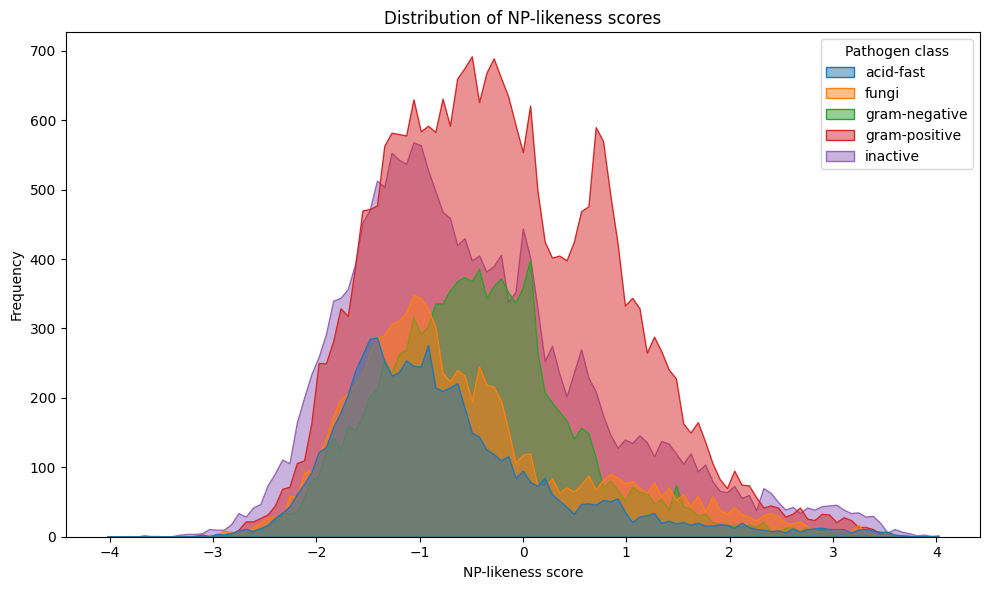

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=cmp_df, x="np_score", hue="Pathogen class", alpha=0.5, element="poly", legend=True
)
plt.xlabel("NP-likeness score")
plt.ylabel("Frequency")
plt.title("Distribution of NP-likeness scores")
plt.tight_layout()
plt.savefig(f"{FIGURE_DIR}/supplementary_figure_2.png", dpi=300)
plt.show()

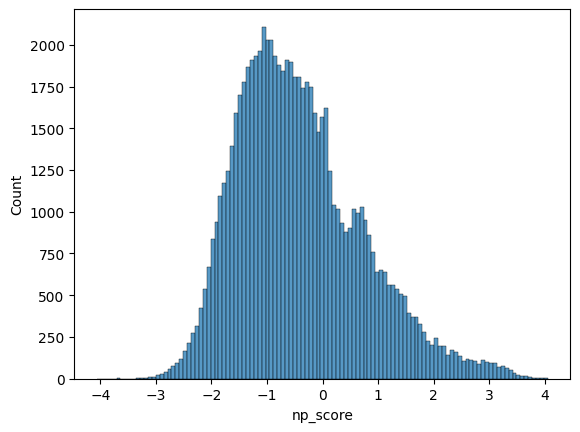

In [9]:
sns.histplot(data=cmp_df, x="np_score")
plt.show()

In [10]:
np_vals = cmp_df["np_score"].values
nps = np_vals[np_vals > 1]
synethetic = np_vals[np_vals < -1]
f"NPs {len(nps)}, Synthetic {len(synethetic)}"

'NPs 8872, Synthetic 25313'